In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_env as pe
import sklearn as sklearn
from scipy import stats
%matplotlib inline

# IMPORT DATA

In [2]:
val_risk = pd.read_csv('val_risk.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)
rearrest_rates = pd.read_csv('rearrest_rates.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)
sada_not_charged = pd.read_csv('sada_not_charged.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

In [3]:
#bring in ADA_CODE, year/month of decision, target variable
data = pd.read_csv('merged.csv', encoding = "ISO-8859-1", low_memory=False)
data_simple = pd.read_csv('data_simple.csv', encoding = "ISO-8859-1", low_memory=False)
                          
                          
val_risk_merged = pd.merge(val_risk, \
                 data[['UNIQUE_ID','NEXT_ARREST_TIME','SCREENING_DISP_DATE','ARREST_DATE_y',\
                      'SCREENING_DISP_DATE_y','SCREENING_DISP_DATE_m']],\
                 on='UNIQUE_ID', \
                 how='left')
val_risk_merged = pd.merge(val_risk_merged, \
                 data_simple[['UNIQUE_ID','ADA_CODE']],\
                 on='UNIQUE_ID', \
                 how='left')


val_risk_merged['NEXT_ARREST_TIME'] = val_risk_merged['NEXT_ARREST_TIME'].apply(pd.to_numeric)

In [4]:
#Create target
_temp, val_risk_merged['REARREST'] = pe.create_target(val_risk_merged,5)
del _temp

In [5]:
#bring in screener info
by_sada = pd.read_csv('by_sada.csv', encoding = "ISO-8859-1", low_memory=False)
val_risk_merged = pd.merge(val_risk_merged, \
                 by_sada,\
                 on='ADA_CODE', \
                 how='left')

In [6]:
#drop if ADA_CODE is missing
val_risk_merged = val_risk_merged.dropna(axis=0, subset = ['ADA_CODE'])

# DISTRIBUTION OF RISK

In [7]:
def predicted_risk_dist(data, risk):
    df = data[data['Risk']>=risk]
    grouped = df.groupby('SCREENING_DISP_DATE_y')['SCREENING_DISP_DATE_y'].count()
    plt.bar(grouped.index, grouped.values)
    plt.xticks(grouped.index, grouped.index.map(str), rotation=45)
    plt.title('Number of Arrestees with Risk > %s' %risk)
    plt.ylabel('Screening Year')
    plt.tight_layout()
    plt.show()

    return grouped

In [8]:
val_risk_merged.columns

Index(['BOFI_NBR', 'UNIQUE_ID', 'Risk', 'NEXT_ARREST_TIME',
       'SCREENING_DISP_DATE', 'ARREST_DATE_y', 'SCREENING_DISP_DATE_y',
       'SCREENING_DISP_DATE_m', 'ADA_CODE', 'REARREST', 'CHRG_ACCEPTED',
       'CHRG_REJECTED', 'NBR_CASES', 'CHRG_RATE'],
      dtype='object')

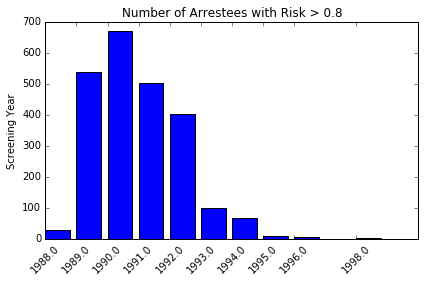

In [9]:
grouped = predicted_risk_dist(val_risk_merged,.80)

# REARREST RATES BY STRICT VS LENIENT

In [10]:
def get_rearrest_rate(sada_list, year):
    '''
    get rearrest rate for list of screeners
    '''
    data_trunc = sada_not_charged[(sada_not_charged['ARREST_DATE_y'] <= 1999 - year)]
    data_trunc = data_trunc[data_trunc['ADA_CODE'].isin(sada_list)]
    total = data_trunc['SCREENING_DISP_CODE'].count()
    rearrest_cnt = data_trunc[(data_trunc['NEXT_ARREST_TIME'] >0)&(data_trunc['NEXT_ARREST_TIME'] <= year*365)]\
            ['SCREENING_DISP_CODE'].count()
    rearrest_rate = rearrest_cnt/total
    return rearrest_rate

In [37]:
len_rate_lower = .3
len_rate_upper = .4
strict_rate_lower = .4
strict_rate_upper = .5
lenient = val_risk_merged[(val_risk_merged['CHRG_RATE']>len_rate_lower)&\
                          (val_risk_merged['CHRG_RATE']<=len_rate_upper)].copy()
strict = val_risk_merged[(val_risk_merged['CHRG_RATE']>strict_rate_lower)&\
                          (val_risk_merged['CHRG_RATE']<=strict_rate_upper)].copy()
years = 5

lenient.sort_values('Risk',ascending=False,inplace=True)

In [38]:
len_sada_list = lenient[['ADA_CODE','NBR_CASES','CHRG_ACCEPTED']].drop_duplicates()
len_chrg_rate =  len_sada_list['CHRG_ACCEPTED'].sum()/len_sada_list['NBR_CASES'].sum()
len_rearrest_rate = get_rearrest_rate(lenient['ADA_CODE'].unique(),years)

strict_sada_list = strict[['ADA_CODE','NBR_CASES','CHRG_ACCEPTED']].drop_duplicates()
strict_chrg_rate =  strict_sada_list['CHRG_ACCEPTED'].sum()/strict_sada_list['NBR_CASES'].sum()
strict_rearrest_rate = get_rearrest_rate(strict['ADA_CODE'].unique(),years)


In [39]:
tot_cases_len = int(lenient.shape[0]/(1-len_chrg_rate))

print('An estimated %s total arrestees were seen by screeners with charge rate between %d%% and %d%% in the validation set.'\
      %(tot_cases_len,len_rate_lower*100,len_rate_upper*100))
print('The weighted average charge rate for those screeners was %d%% and %d%% of those released were rearrested\n'\
      %(len_chrg_rate*100,len_rearrest_rate*100))

tot_cases_strict = int(strict.shape[0]/(1-strict_chrg_rate))

print('%s total arrestees seen by screeners with charge rate between %d%% and %d%% in the validation set.'\
      %(tot_cases_strict,strict_rate_lower*100,strict_rate_upper*100))
print('The weighted average charge rate for those screeners was %d%% and %d%% of those released were rearrested\n'\
      %(strict_chrg_rate*100,strict_rearrest_rate*100))

target_chrgs = int(tot_cases_len*(strict_chrg_rate-len_chrg_rate))
marginal_rearrest_rate = lenient[:target_chrgs]['REARREST'].sum()/target_chrgs
tot_rearrest_rate = (lenient['REARREST'].sum()-lenient[:target_chrgs]['REARREST'].sum())/\
                    (tot_cases_len*(1-len_chrg_rate)-target_chrgs)
new_chrg_rate = (len_chrg_rate*tot_cases_len+target_chrgs)/tot_cases_len

print('%s additional arrestees need to be charged for the lenient screeners to have a charge rate of %d%%.'\
      %(target_chrgs,strict_chrg_rate*100))
print('Out of the %s predicted riskiest arrestees, %d were rearrested, a rearrest rate of %d%%.' \
      %(target_chrgs,marginal_rearrest_rate*target_chrgs,marginal_rearrest_rate*100))
print('If those %s were charged, the rearrest rate for the "lenient screeners" would be %d%%.' \
      %(target_chrgs,tot_rearrest_rate*100))
print('If those %s were charged, the charge rate for the "lenient screeners" would be %d%%.' \
      %(target_chrgs,new_chrg_rate*100))

An estimated 7747 total arrestees were seen by screeners with charge rate between 30% and 40% in the validation set.
The weighted average charge rate for those screeners was 35% and 54% of those released were rearrested

3580 total arrestees seen by screeners with charge rate between 40% and 50% in the validation set.
The weighted average charge rate for those screeners was 43% and 53% of those released were rearrested

565 additional arrestees need to be charged for the lenient screeners to have a charge rate of 43%.
Out of the 565 predicted riskiest arrestees, 513 were rearrested, a rearrest rate of 90%.
If those 565 were charged, the rearrest rate for the "lenient screeners" would be 48%.
If those 565 were charged, the charge rate for the "lenient screeners" would be 43%.


In [81]:
def get_p_value(threshold, n=1000):
    rearrest_rates = np.zeros(n)
    for i in range(n):
        lenient_rand = lenient.reindex(np.random.permutation(lenient.index))
        rearrest_rates[i] = (lenient['REARREST'].sum()-lenient_rand[:target_chrgs]['REARREST'].sum())/\
                        (tot_cases_len*(1-len_chrg_rate)-target_chrgs)
    p_value = len(rearrest_rates[rearrest_rates<=threshold])/n
    return p_value, rearrest_rates

In [83]:
p_value, rearrest_rates_rand = get_p_value(.49, n=1000)

In [84]:
p_value

0.0

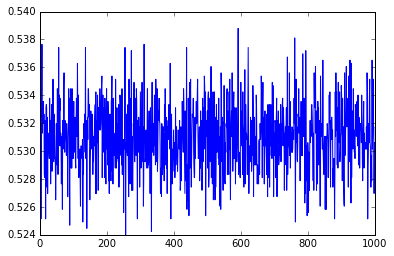

In [85]:
plt.plot(rearrest_rates_rand)

# Rearrest Rates by Predicted Risk

In [20]:
val_risk_merged.head()

,BOFI_NBR,UNIQUE_ID,Risk,NEXT_ARREST_TIME,SCREENING_DISP_DATE,ARREST_DATE_y,SCREENING_DISP_DATE_y,SCREENING_DISP_DATE_m,ADA_CODE,REARREST,CHRG_ACCEPTED,CHRG_REJECTED,NBR_CASES,CHRG_RATE
1,325011,127976,0.047620,0,1992-03-30,1992.0,1992.0,3.0,PMOR,0,522.0,716.0,1238.0,0.421648
3,306688,63012,0.935873,137,1991-11-19,1990.0,1991.0,11.0,CKEM,1,1726.0,3523.0,5249.0,0.328825
4,310664,81452,0.388982,409,1991-03-27,1991.0,1991.0,3.0,JHAN,1,222.0,311.0,533.0,0.416510
6,188857,81615,0.400215,1,1993-06-02,1993.0,1993.0,6.0,JLUC,1,4434.0,3610.0,8044.0,0.551218
7,317574,105477,0.296574,545,1993-04-07,1993.0,1993.0,4.0,DLIL,1,569.0,939.0,1508.0,0.377321


In [15]:
def chrg_rate_by_risk(chrg_rate_lower,chrg_rate_upper):
    chrg_rate_bin = val_risk_merged[(val_risk_merged['CHRG_RATE']>chrg_rate_lower)&\
                              (val_risk_merged['CHRG_RATE']<=chrg_rate_upper)].copy()
    chrg_rate_bin['quintile'] = pd.qcut(chrg_rate_bin['Risk'],5,labels=False)
    chrg_rate_bin['count'] = 1
    chrg_rate_bin_q = chrg_rate_bin.groupby('quintile')[['REARREST','count']].sum()
    chrg_rate_bin_q['rearrest_rate']=chrg_rate_bin_q['REARREST']/chrg_rate_bin_q['count']
    print('Arrestees released by screeners with charge rates of %d%% to %d%%' %(chrg_rate_lower*100,chrg_rate_upper*100))
    print(chrg_rate_bin_q)

In [22]:
chrg_rate_by_risk(0,1)
chrg_rate_by_risk(.3,.4)
chrg_rate_by_risk(.4,.5)
chrg_rate_by_risk(.5,.6)

Arrestees released by screeners with charge rates of 0% to 100%
          REARREST  count  rearrest_rate
quintile                                
0              233   1836       0.126906
1              592   1835       0.322616
2              969   1836       0.527778
3             1387   1835       0.755858
4             1612   1836       0.877996


In [23]:
chrg_rate_by_risk(0,1)

Arrestees released by screeners with charge rates of 0% to 100%
          REARREST  count  rearrest_rate
quintile                                
0              233   1836       0.126906
1              592   1835       0.322616
2              969   1836       0.527778
3             1387   1835       0.755858
4             1612   1836       0.877996
